# Complete Graph

### Libraries

In [1]:
## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import classic

## node colour
color_map = ["steelblue"]

### Supporting Functions

In [2]:
## supporting functions
from support.preprocessing import sort_adjacency, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single, generate_manifold, generate_topol_manifold, generate_topol_manifold
from support.param_generating import generate_param_graph_manifold, generate_param_topol_manifold
from support.latent_space import vis2D, visDistr

## import model
from models.VAE import VAE

Using TensorFlow backend.


## Loading and Preprocessing Network Data

### Loading Network Data

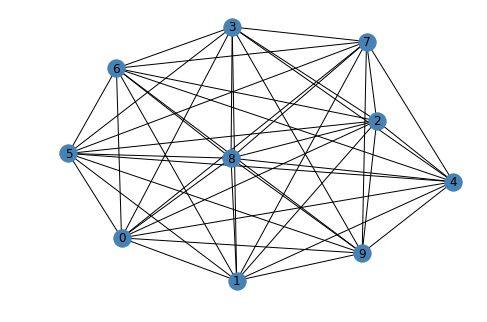

In [3]:
def get_graph(n,draw): 

    g = classic.complete_graph(n)

    if draw:
        nx.draw(g, node_color = color_map, with_labels = True)
        plt.show()
    
    return g

g = get_graph(n = 10, draw = True)

# Generating Training Data

In [4]:
def generate_data(dataArgs): 
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], diag_offset = dataArgs["diag_offset"])))

    ## Ground Truth Labels ______________________________

    T = list()
    T_array = np.zeros((dataArgs["n_graphs"],1))

    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):

        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

        g = get_graph(n, draw = False)

        g, a = sort_adjacency(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])


        ## Build Data Arrays___________________________________________________

        G[i] = a_transformed

        t = dict()
        t["n"] = n

        T.append(t)
        T_array[i] = [n]



    ## Input and Output Size ___________________________________________________________

    T, input_shape, output_shape = prepare_in_out(T, dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]))
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale parameters in T_array for smoother training
    scaler = MinMaxScaler()
    scaler.fit(T_array)
    T_array = scaler.transform(T_array)
    
    return G,T,T_array,input_shape,output_shape,scaler
    
dataArgs = {"n_graphs": 10000, "n_max": 20, "fix_n": False, "diag_offset": 0, "diag_value": 1, "clip": True}  #"diag_offset" - 1 == full adjacency
G, T, T_array, input_shape, output_shape,scaler = generate_data(dataArgs)


input_shape: (210,) , output_shape: 210


# beta-VAE (MLP, 2D_Conv)

## Build and Train Model

In [5]:
# network parameters
modelArgs = {"nn_architecture": "mlp", "param_loss": False, "latent_dim": 2, "growth_param": T_array.shape[1], "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape}
trainArgs = {"beta": 10, "loss": "binary_crossentropy", "weights": "train", "early_stop": 2, "batch_size": 128, "epochs": 50, "data_split": 0.2}

vae = VAE(modelArgs, trainArgs, G, T_array)

models = vae.model 
data = vae.data

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 210)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          27008       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            130         dense_2[0][0]                    
_____________________________________

# Latent Space Analysis

# Encoder

# Iterate through single data dimension and oberseve single latent space dimension  

/usr/local/lib/python3.7/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


Mutual Information Gap: 0.5039461126367596


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


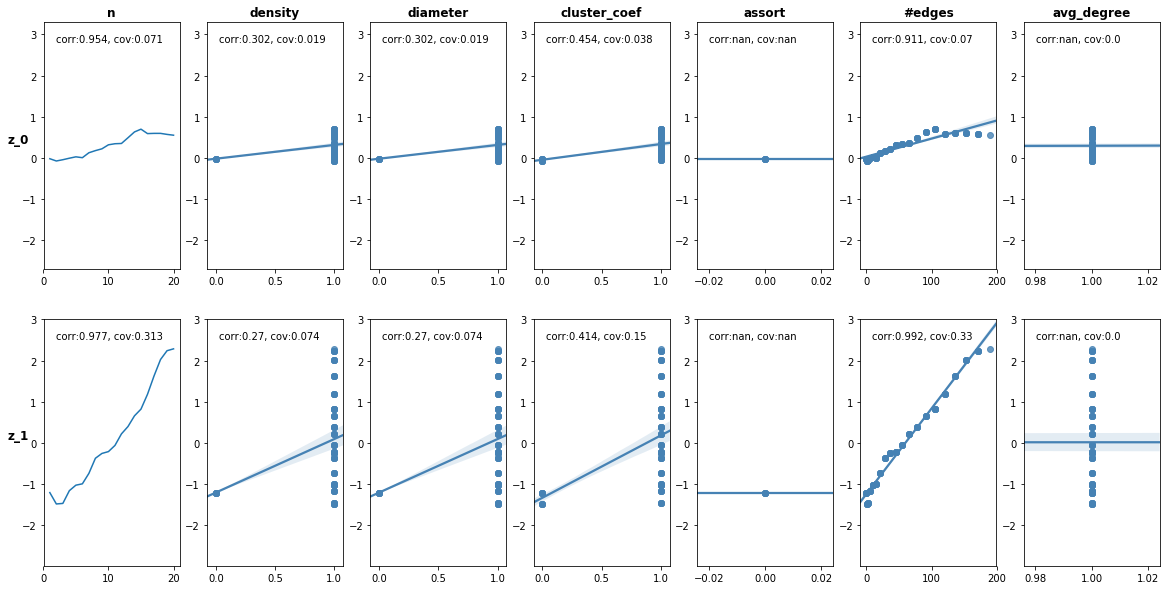

In [6]:
def latent_space_feature_correlation(analyzeArgs, modelArgs, models,batch_size=128,model_name="vae_graph"):

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models
    
    if analyzeArgs["root_params"] == 1 or modelArgs["latent_dim"] == 1:
        
        ## Generate Graph Data_______________________________
            
        N = np.linspace(1,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype = int)  # array 0.1, 0.2 - 1 / n_config_graphs  
        
        ## growth and topol parameters
        growth_topol_params = ["n","density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]
        
        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth_Topol = np.zeros((analyzeArgs["n_config_graphs"], len(growth_topol_params)))
    
        for i, n in enumerate(N):

            ## Generate Graph Type ______________________________________________

            g = get_graph(int(n), draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth_Topol[i,0] = n
            Growth_Topol[i,1] = density
            Growth_Topol[i,2] = diameter
            Growth_Topol[i,3] = cluster_coef
            Growth_Topol[i,4] = assort
            Growth_Topol[i,5] = edges
            Growth_Topol[i,6] = avg_degree

  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
        
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            mig = compute_mig(N, np.squeeze(z_mean))
            
        
        ## Visualize Latent Variables x Graph Properties ____________________________
        fig, ax = plt.subplots(nrows= z_mean.shape[1], ncols= Growth_Topol.shape[1], figsize=(20, 10))

        for latent_z, row in enumerate(ax):  
            
            if z_mean.shape[1] == 1:   # only one latent variable
                
                if latent_z == 0:
                    y = z_mean[:,0]
                    x = Growth_Topol[:,latent_z]
                    row.plot(x, y) 

                else:
                    y = z_mean[:,0]
                    x = Growth_Topol[:,latent_z]
                    #row.scatter(x, y) 
                    sns.regplot(x, y, color="steelblue", ax=row)

                    ## plot trend line
                    #x = np.nan_to_num(x)
                    #y = np.nan_to_num(y)

                    #z = np.polyfit(x, y, 1)
                    #p = np.poly1d(z)
                    #row.plot(x,p(x),"steelblue")
                    
                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                row.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')
                row.set_ylim([np.mean(y) - 3.0, np.mean(y) + 3.0])


                    
            else:                     # multiple latent variables
                
                for feature, col in enumerate(row):

                    if feature == 0:
                        y = z_mean[:,latent_z]
                        x = Growth_Topol[:,feature]
                        col.plot(x, y) 

                    else:
                        y = z_mean[:,latent_z]
                        x = Growth_Topol[:,feature]
                        #col.scatter(x, y) 
                        sns.regplot(x, y, color="steelblue", ax=col)
                
                        ## plot trend line
                        #x = np.nan_to_num(x)
                        #y = np.nan_to_num(y)

                        #z = np.polyfit(x, y, 1)
                        #p = np.poly1d(z)
                        #col.plot(x,p(x),"steelblue")
            
                    col.set_ylim([np.mean(y) - 3.0, np.mean(y) + 3.0])

                    ## compute correlation and standardized covariance
                    corr = round(pearsonr(x,y)[0],3)
                    cov = round(np.cov(x, y)[0][1]/max(x),3)
                    col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________
        
        if z_mean.shape[1] == 1:   # only one latent variable
                
            cols = [t for t in growth_topol_params]
            
            for axis, col in zip(ax[:,], cols):
                axis.set_title(col, fontweight='bold')
                
        
        if z_mean.shape[1] != 1:   # more than one latent variable
            
            rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
            cols = [t for t in growth_topol_params]

            for axis, row in zip(ax[:,0], rows):
                axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')
            
            for axis, col in zip(ax[0], cols):
                axis.set_title(col, fontweight='bold')

        plt.show()



## PLOT RESULTS ________________________________________

analyzeArgs = {"root_params": 1, "n_config_graphs": 100, "metric": "mig"}
latent_space_feature_correlation(analyzeArgs, modelArgs, models, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize the Latent Space in 2D

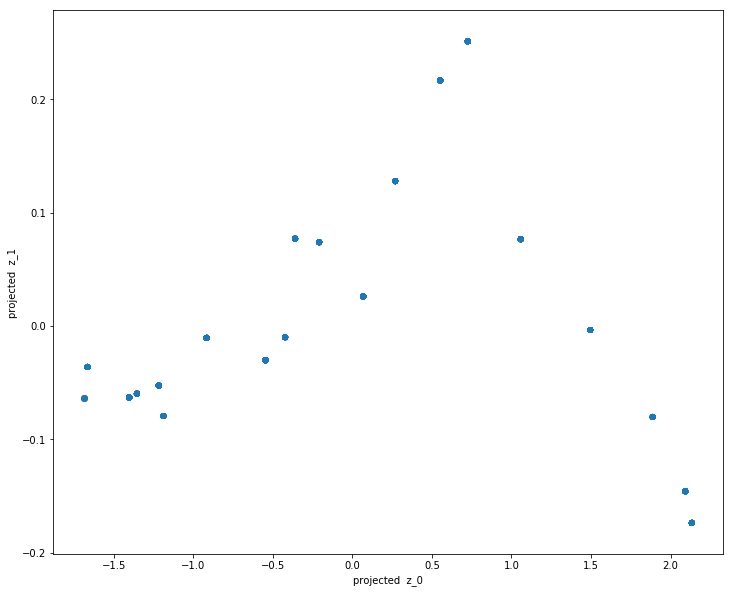

In [7]:
analyzeArgs = {"save_plots": False}
vis2D(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

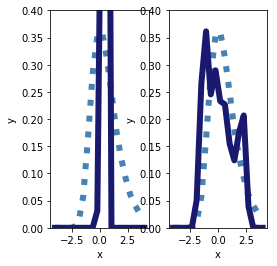

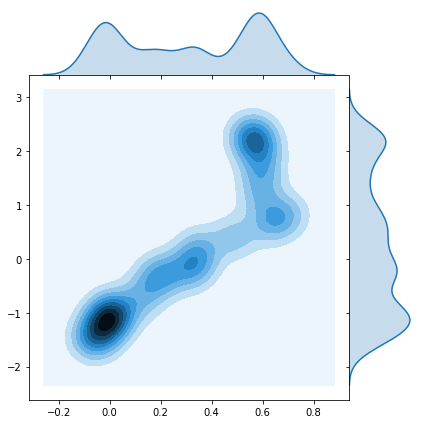

In [8]:
analyzeArgs = {"z": [0,1]}
visDistr(modelArgs, analyzeArgs, models,data,trainArgs["batch_size"])

# Decoder

## Generate a Single Graph Instance

latent dimensions: 2


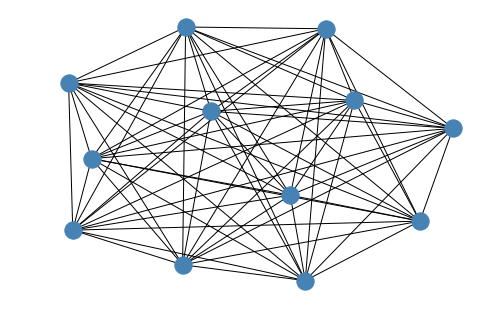

In [9]:
analyzeArgs = {"activations": [0, 0.2], "z": [0,1]}
generate_single(analyzeArgs, modelArgs, dataArgs, models, color_map)

## Generate Interpolated Manifold from Latent Space

latent dimensions: 2


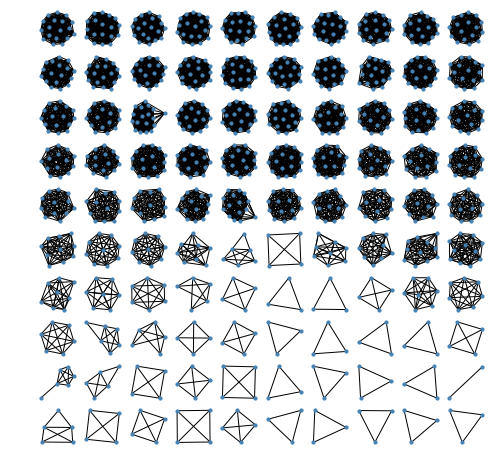

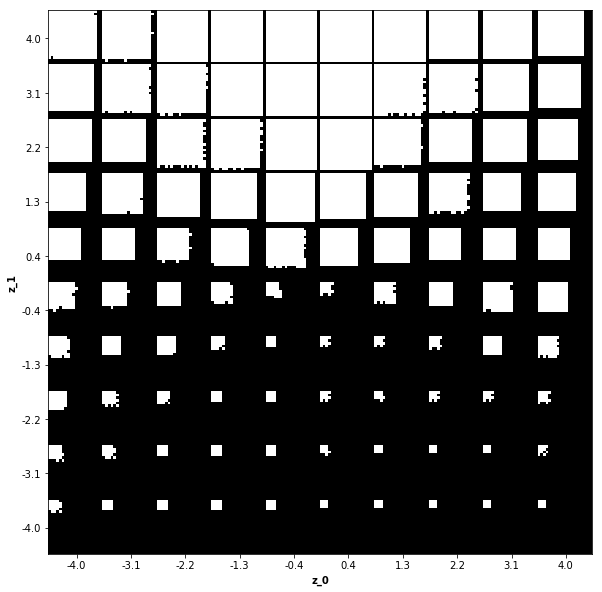

In [10]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

latent dimensions: 2


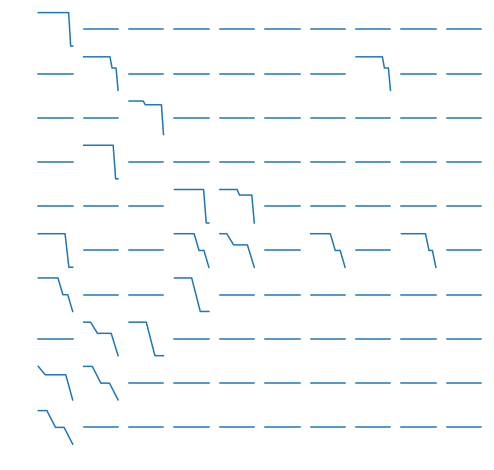

In [11]:
analyzeArgs = {"z": [0,1], "plot": "distr", "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

## "density", "cluster_coef", "assort", "avg_degree"

## Analyze Parameter Encoding

In [12]:
## range, normal, z
analyzeArgs = {"z": [0,1], "graph_type": "Complete", "sample": "normal", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_param_graph_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)

## "cluster_coef", "assort", "avg_degree"

latent dimensions: 2


SystemExit: modelArgs[param_loss] should be True

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3273: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
generate_param_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)

latent dimensions: 2


SystemExit: modelArgs[param_loss] should be True

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3273: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
